## Implementation factors

In [1]:
using Distributions
mu_1 = 8.0
sig_1 = sqrt(2)
mu_2 = 12.0
sig_2 = sqrt(2)
beta = 1#sqrt(1.0)

f_1(s1::Int) = pdf(Normal(mu_1, sig_1), s1)
f_2(s1::Int, p1::Int) = pdf(Normal(s1, beta), p1)
f_3(s2::Int) = pdf(Normal(mu_2, sig_2), s2)
f_4(s2::Int, p2::Int) = pdf(Normal(s2, beta), p2)
f_5(p1::Int, p2::Int, d::Int) = (p1 - p2 == d) ? 1.0 : 0.0 
f_6(d::Int) = if d > 0 ? 1.0 : 0.0 end

f_6 (generic function with 1 method)

## Implementation marginalization

In [2]:
# marginalization for s1

function marginalize_s1(N::Int, s1::Int)
    sum = 0.0
    for s2 in 1:N
        inner_sum_s2 = 0.0
        for p1 in 1:N
            inner_sum_p1 = 0.0
            for p2 in 1:(p1 - 1) # its not wrong
                inner_sum_p1 += f_4(s2, p2)
            end
            inner_sum_p1 *= f_2(s1, p1)
            inner_sum_s2 += inner_sum_p1
        end
        inner_sum_s2 *= f_3(s2)
        sum += inner_sum_s2
    end
    return sum * f_1(s1)
end

marginalize_s1 (generic function with 1 method)

### For s2 we implemented both a naive and slightly improved version

naive

In [3]:
# marginalization for s1

function marginalize_s2(N::Int, s2::Int)
    sum = 0.0
    for s1 in 1:N
        inner_sum_s1 = 0.0
        for p1 in 1:N
            inner_sum_p1 = 0.0
            for p2 in 1:(p1-1) # its not wrong
                inner_sum_p1 += f_4(s2, p2)
            end
            inner_sum_p1 *= f_2(s1, p1)
            inner_sum_s1 += inner_sum_p1
        end
        inner_sum_s1 *= f_1(s1)
        sum += inner_sum_s1
    end
    return sum * f_3(s2)
end

marginalize_s2 (generic function with 1 method)

improved

In [4]:
function marginalize_s2_2(N::Int, s2::Int)
    sum = 0.0
    for s1 in 1:N
        for p1 in 1:N
            for p2 in 1:(p1 - 1) # its not wrong
                sum += (f_4(s2, p2) * f_2(s1, p1) * f_1(s1) * f_3(s2))
            end
        end
    end
    return sum
end

marginalize_s2_2 (generic function with 1 method)

In [5]:
function marginalize_p1(N::Int, p1::Int)
    sum = 0.0
    for s1 in 1:N
        inner_sum_s2= 0.0
        for s2 in 1:N
            inner_sum_p2 = 0.0
            for p2 in 1:(p1-1)
                inner_sum_p2 += f_4(s2, p2)
            end
            inner_sum_s2 += (f_3(s2) * inner_sum_p2)
        end
        sum += (f_1(s1) * f_2(s1,p1) * inner_sum_s2) 
    end
    return sum
end

marginalize_p1 (generic function with 1 method)

In [6]:
function marginalize_p2(N::Int, p2::Int)
    sum = 0.0
    for s1 in 1:N
        inner_sum_s2 = 0.0
        for s2 in 1:N
            inner_sum_p1 = 0.0
            for p1 in (p2+1):N
                inner_sum_p1 += f_2(s1, p1)
            end
            inner_sum_s2 += inner_sum_p1 * (f_3(s2) * f_4(s2, p2))
        end
        sum += (inner_sum_s2 * f_1(s1))
    end
    return sum
end

marginalize_p2 (generic function with 1 method)

In [7]:
function marginalize_p2_2(N::Int, p2::Int)
    sum = 0.0
    for s1 in 1:N
        for s2 in 1:N
            for p1 in (p2+1):N
                sum += f_1(s1) * f_2(s1, p1) * f_3(s2) * f_4(s2, p2)
            end
        end
    end
    return sum
end

marginalize_p2_2 (generic function with 1 method)

In [8]:
function marginalize_d(N::Int, d::Int)
    if d <= 0
        return 0.0
    end
    sum = 0.0
    for s1 in 1:N
        inner_sum_s2 = 0.0
        for s2 in 1:N
            inner_sum_p1 =0.0
            for p1 in d:N
                inner_sum_p1 += f_2(s1, p1) * f_4(s2, p1 - d)
            end
            inner_sum_s2 += (inner_sum_p1 * f_3(s2))
        end
        sum = f_1(s1) * inner_sum_s2
    end
    return sum
end

marginalize_d (generic function with 1 method)

## Sum-Product algorithm

this is an incorrect implementation that we kept for debuggin purposes

In [9]:
"""#forward
function_mf1_s1(s1::Int) = f_1(s1)
function_mf3_s2(s2::Int) = f_3(s2)
function_f_p_s1(s1::Int) = function_mf1_s1(s1) 
function_f_p_s2(s2::Int) = function_mf3_s2(s2)
function_mf2_p1(N::Int, p1::Int) = sum([f_2(s1, p1) * function_f_p_s1(s1) for s1 in 1:N])
function_mf4_p2(N::Int, p2::Int) = sum([f_4(s2, p2) * function_f_p_s2(s2) for s2 in 1:N])
function_f_p_p1(N::Int, p1::Int) = function_mf2_p1(N, p1) 
function_f_p_p2(N::Int, p2::Int) = function_mf4_p2(N, p2)
function_mp1_f5(N::Int, p1::Int) = function_f_p_p1(N, p1)
function_mp2_f5(N::Int, p2::Int) = function_f_p_p2(N, p2)
function_mf5_d(N::Int, d::Int) = sum((f_5(p1, p1 - d, d) *  function_mp1_f5(N,p1) * function_mp2_f5(N,p1 - d)) for p1 in d:N)
function_f_p_d(N::Int, d::Int) = function_mf5_d(N,d)

#backward
#observer d = 1
function_mf6_d(d::Int) = (d > 0.0) ? 1.0 : 0.0
function_p_d(N::Int, d::Int) = function_mf6_d(d) > 0.0 ? function_mf5_d(N,d) : 0.0
function_md_f5(N::Int, d::Int) = (function_mf5_d(N, d) > 0.0 )  ? (function_p_d(N, d) / function_mf5_d(N, d)) : 0.0
function_mf5_p1(N::Int, p1::Int) = sum((function_md_f5(N, d) *  function_mp2_f5(N, p1 - d)) for d in 1:N) # d = p1 - p2, p2 = p1 - d
function_mf5_p2(N::Int, p2::Int) = sum((function_md_f5(N, d) *  function_mp1_f5(N, p2 + d)) for d in 1:N) # p1 = p2 + d
function_p_p1(N::Int, p1::Int ) = function_mf2_p1(N, p1) * function_mf5_p1(N, p1) # sum()
function_p_p2(N::Int, p2::Int ) = function_mf4_p2(N, p2) * function_mf5_p2(N, p2)
function_mf2_s1(N::Int, s1::Int) = sum( ( f_2(s1, p1) * (function_p_p1(N,p1) / function_mf2_p1(N, p1)) ) for p1 in 1:N)
function_mf4_s2(N::Int, s2::Int) = sum( ( f_4(s2, p2) * (function_p_p2(N,p2) / function_mf4_p2(N, p2)) ) for p2 in 1:N)
function_p_s1(N::Int, s1::Int) = function_mf1_s1(s1) * function_mf2_s1(N,s1)
function_p_s2(N::Int, s2::Int) = function_mf3_s2(s2) * function_mf4_s2(N, s2)
"""

"#forward\nfunction_mf1_s1(s1::Int) = f_1(s1)\nfunction_mf3_s2(s2::Int) = f_3(s2)\nfunction_f_p_s1(s1::Int) = function_mf1_s1(s1) \nfunction_f_p_s2(s2::Int) = function_mf3_s2(s2)\nfunction_mf2_p1(N::Int, p1::Int) = sum([f_2(s1, p1) * function_f_p_s1(s1) for s1 in 1:N])\nfunction_mf4" ⋯ 1310 bytes ⋯ "nction_mf4_s2(N::Int, s2::Int) = sum( ( f_4(s2, p2) * (function_p_p2(N,p2) / function_mf4_p2(N, p2)) ) for p2 in 1:N)\nfunction_p_s1(N::Int, s1::Int) = function_mf1_s1(s1) * function_mf2_s1(N,s1)\nfunction_p_s2(N::Int, s2::Int) = function_mf3_s2(s2) * function_mf4_s2(N, s2)\n"

This is our implementation

In [10]:
# calculating using vector
#forward

function calculateAllMarginalsViaMsg(N::Int=20)
    #N = 20
    mf1_s1 = [f_1(s1) for s1 in 1:N]
    mf3_s2 = [f_3(s2) for s2 in 1:N]
    f_p_s1 = copy(mf1_s1)
    f_p_s2 = copy(mf3_s2)
    mf2_p1 = [sum([f_2(s1, p1) * f_p_s1[s1] for s1 in 1:N]) for p1 in 1:N]
    mf4_p2 = [sum([f_4(s2, p2) * f_p_s2[s2] for s2 in 1:N]) for p2 in 1:N]
    f_p_p1 = copy( mf2_p1 )
    f_p_p2 = copy(mf4_p2)
    mp1_f5 = copy(f_p_p1)
    mp2_f5 = copy(f_p_p2)
    mf5_d = [sum([f_5(p1, p1 - d, d) *  mp1_f5[p1] * mp2_f5[p1 - d] for p1 in max(d + 1,1): min(N,N + d) ];init = 0.0) for d in -N:N]
    f_p_d = copy(mf5_d)

    #backward
    #observer d = 1
    mf6_d = [(d > 0.0) ? 1.0 : 0.0 for d in -N:N]
    p_d =  [ mf6_d[d + N + 1] > 0.0 ? mf5_d[d+ N + 1] : 0.0 for d in -N:N]
    md_f5 = [(mf5_d[d + N + 1] > 0.0 ) ? (p_d[d + N + 1] / mf5_d[d + N + 1]) : 0.0 for d in -N:N]
    mf5_p1 = [sum([md_f5[d+N+1] * mp2_f5[p1 - d] for d in 1:(p1-1)]; init=0.0) for p1 in 1:N]
    mf5_p2 = [ sum([md_f5[d + N + 1 ] *  mp1_f5[p2 + d] for d in 1:(N - p2)]; init = 0.0) for p2 in 1:N ] # p2 + d = p1 / p1 in 1:N -> d 1:N-p2 
    p_p1 = [ (mf2_p1[p1] * mf5_p1[p1]) for p1 in 1:N]
    p_p2 = [ (mf4_p2[p2] * mf5_p2[p2]) for p2 in 1:N]
    mf2_s1 = [ sum([ f_2(s1, p1) * (p_p1[p1] / mf2_p1[p1]) for p1 in 1:N ]) for s1 in 1:N ]
    mf4_s2 = [sum([  f_4(s2, p2) * (p_p2[p2] / mf4_p2[p2]) for p2 in 1:N]) for s2 in 1:N]
    p_s1 = [mf1_s1[s1] * mf2_s1[s1] for s1 in 1:N]
    p_s2 = [mf3_s2[s2] * mf4_s2[s2] for s2 in 1:N]

    return (p_s1, p_s2, p_p1, p_p2, p_d)
end


calculateAllMarginalsViaMsg (generic function with 2 methods)

In [11]:
p_s1, p_s2, p_p1, p_p2, p_d = calculateAllMarginalsViaMsg()

([4.278917360864382e-15, 1.98493366542437e-12, 4.358609397206976e-10, 4.54273009573138e-8, 2.250977470758986e-6, 5.313882431802025e-5, 0.0005993230673042506, 0.003241867176939166, 0.008455567651416591, 0.010714592933109834, 0.0066669829698692215, 0.0020680640357148773, 0.0003265987176974663, 2.700702886671425e-5, 1.2104888010303388e-6, 3.052372680628535e-8, 4.4756126484021037e-10, 3.88913638434922e-12, 1.9343908656763095e-14, 4.576321900464531e-17], [1.436943260690744e-14, 3.677616279038942e-12, 4.4555441791735476e-10, 3.051947831117188e-8, 1.2104867941936796e-6, 2.7007028655495332e-5, 0.00032659871769722646, 0.0020680640357597776, 0.006666982970127755, 0.010714592934012205, 0.00845556765332691, 0.003241867179392064, 0.00059932306921457, 5.3138825220391205e-5, 2.2509777292922104e-6, 4.542734587763754e-8, 4.3586565330131337e-10, 1.98521865070465e-12, 4.287127327015179e-15, 4.383232190169889e-18], [0.0, 2.294348830600028e-13, 4.895712674285502e-11, 5.2730656193049294e-9, 2.92853551679205

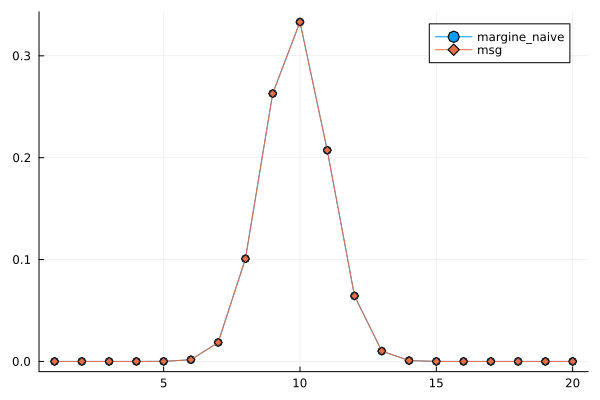

20

In [42]:
using Plots

gr()   
N_PLOT = 20
# x values
xs = 1:N_PLOT
p_s1, p_s2, p_p1, p_p2, p_d = calculateAllMarginalsViaMsg(N_PLOT)

margin_s1 = [marginalize_s1(N_PLOT, i ) for i in xs]
msg_s1 = p_s1
print(length(msg_s1))

margin_s1_norm = margin_s1 / sum(margin_s1)
msg_s1_norm = msg_s1 / sum(msg_s1)


plt = plot(xs, msg_s1_norm,
           label = "margine_naive",
           marker = :o)

plot!(plt, xs, msg_s1_norm,
      label = "msg",
      marker = :diamond)

display(plt)


In [53]:
using Plots

function plot_compare_s2_centered(N)

    x = 1:N
    y1 = [marginalize_s2(N, s2)   for s2 in x]
    y2 = [marginalize_s2_2(N, s2) for s2 in x]
    
    p_s1, p_s2, p_p1, p_p2, p_d = calculateAllMarginalsViaMsg(N)
    y3 = p_s2

    l = @layout [ a b c
                  _ d _ ]

    plt = plot(layout=l, size=(1200,600))

    plot!(plt[1], x, y1, title="marginalize s2 naive", xlabel="s2" )
    plot!(plt[2], x, y2, title="marginalize s2 (improved)", xlabel="s2")
    plot!(plt[3], x, y3, title="marginalize s2 (sum-prod)", xlabel="s2")

    # --- Row 2: centered combined plot with equal width ---
    plot!(plt[4], x, y1, label="naive", xlabel="s2" )
    plot!(plt[4], x, y2, label="improved")
    plot!(plt[4], x, y3, label="sum-prod")
    title!(plt[4], "All curves")

    return plt
end


plot_compare_s2_centered (generic function with 1 method)

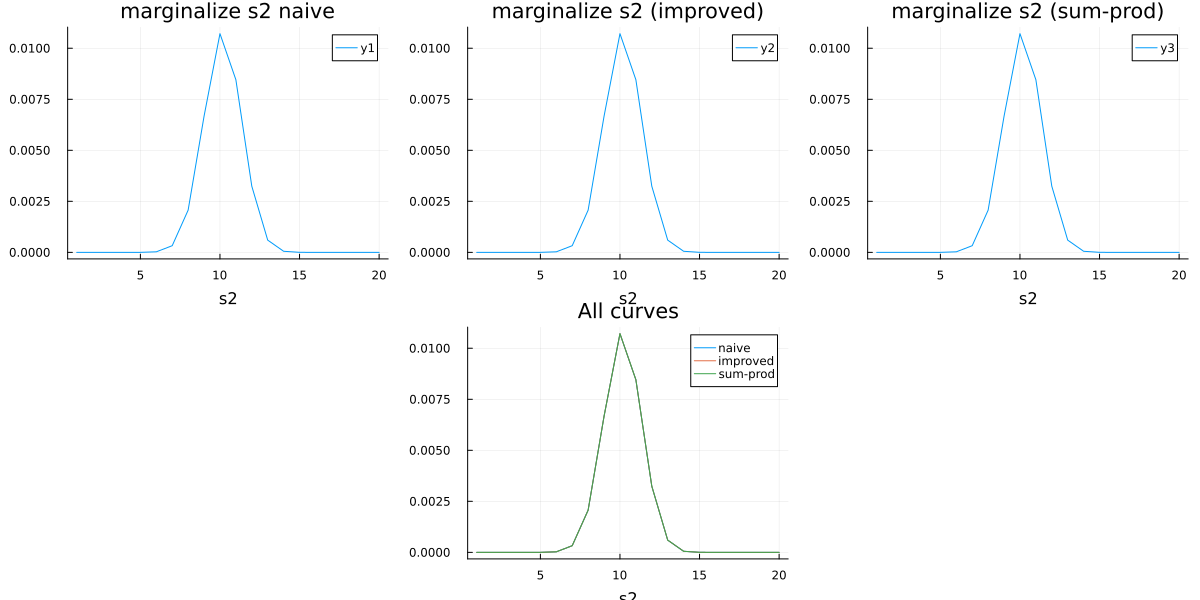

In [54]:
plot_compare_s2_centered(20)

In [43]:
function calculateAllMarginals()
    N = 20
    for i in 1:N marginalize_s1(20, i) end
    for i in 1:N marginalize_s2(20, i) end
    for i in 1:N marginalize_p1(20, i) end
    for i in 1:N marginalize_p2(20, i) end
    for i in -N:N marginalize_d(20, i) end
end

calculateAllMarginals (generic function with 1 method)

In [45]:
using BenchmarkTools
t1 = @belapsed calculateAllMarginalsViaMsg()
t2 = @belapsed calculateAllMarginals()

println("ViaMsg: $t1 seconds")
println("Direct: $t2 seconds")
println("Speedup: ", t2 / t1, "× (ViaMsg vs Direct)")

ViaMsg: 0.0004335 seconds
Direct: 0.1724192 seconds
Speedup: 397.73748558246825× (ViaMsg vs Direct)
